# View Occlusion Sensitivity

In [1]:
import matplotlib.pyplot as plt
from keras.applications.inception_v3 import InceptionV3, preprocess_input, decode_predictions
from keras.layers import Input
import cv2 as cv
import tensorflow as tf
import numpy as np

In [2]:
# To avoid: 
# StdErr from Kernel Process OMP: Error #15: Initializing libiomp5md.dll, but found libiomp5 already initialized. 
# OMP: Hint This means that multiple copies of the OpenMP runtime have been linked into the program.

import os

os.environ['KMP_DUPLICATE_LIB_OK'] = 'True'

This code imports InceptionV3 and a test image.

In [3]:
model = InceptionV3(input_tensor=Input(shape=(224, 224, 3)))
model.summary()

Model: "inception_v3"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 224, 224, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv2d (Conv2D)                (None, 111, 111, 32  864         ['input_1[0][0]']                
                                )                                                                 
                                                                                                  
 batch_normalization (BatchNorm  (None, 111, 111, 32  96         ['conv2d[0][0]']                 
 alization)                     )                                                      

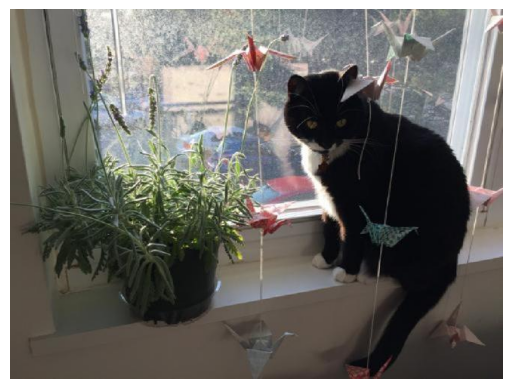

In [4]:
cat = cv.imread("../data/cat.jpg")
cat = cv.cvtColor(cat, cv.COLOR_BGR2RGB)

plt.figure()
plt.imshow(cat)
plt.axis("off")
plt.show()

An image cat.jpg has been imported. There's a few different objects in this image, including a cat, a plant, and some origami. 

In [5]:
cat_preprocessed = cv.resize(cat, dsize=(224, 224))
cat_preprocessed = preprocess_input(cat_preprocessed)
cat_preprocessed = tf.expand_dims(cat_preprocessed, axis=0)

In [6]:
prediction = model.predict(cat_preprocessed, verbose=False)
prediction = decode_predictions(prediction, top=10)[0][0][1]
prediction

'Egyptian_cat'

The classification is 'Egyptian_cat'. Why did the network make that prediction? We can use a technique called occlusion sensitivity to visualize which parts of an image are important for a classification.

In [7]:
def occlusion_sensitivity(model, image, class_index, patch_size):
    # Create function to apply a gray patch on an image
    def apply_gray_patch(image, top_left_x, top_left_y, patch_size):
        patched_image = np.array(image, copy=True)
        patched_image[top_left_y:top_left_y + patch_size, top_left_x:top_left_x + patch_size, :] = 128

        return patched_image

    image = cv.resize(image, dsize=(224, 224))
    sensitivity_map = np.zeros((image.shape[0], image.shape[1]))
    
    # Iterate the patch over the image
    for top_left_x in range(0, image.shape[0], patch_size):
        for top_left_y in range(0, image.shape[1], patch_size):
            patched_image = apply_gray_patch(image, top_left_x, top_left_y, patch_size)
            patched_image = preprocess_input(patched_image)
            patched_image = tf.expand_dims(patched_image, axis=0)
            predicted_classes = model.predict(patched_image, verbose=False)[0]
            confidence = predicted_classes[class_index]
            
            # Save confidence for this specific patched image in map
            sensitivity_map[top_left_y:top_left_y + patch_size, top_left_x:top_left_x + patch_size] = 1 - confidence

    sensitivity_map = (sensitivity_map - sensitivity_map.min()) / (sensitivity_map.max() - sensitivity_map.min()) # Normalize
    sensitivity_map = plt.get_cmap('jet')(sensitivity_map)[:, :, :3] * 255 # RGB heatmap

    return sensitivity_map

In [8]:
sensitivity_map = occlusion_sensitivity(model, cat, 285, 10)

To view the sensitivity map, we'll overlay map on the cat image. To overlay the sensitivity map, we can use the [addWeighted()](https://docs.opencv.org/3.4/d2/de8/group__core__array.html#gafafb2513349db3bcff51f54ee5592a19) function with a low alpha value.
The alpha value a is a number from 0 to 1, where 0 transparent and 1 is opaque.

In [9]:
cat_sensitivity_map = cv.addWeighted(cv.resize(cat, dsize=(224, 224)), 0.5, sensitivity_map.astype(np.uint8), 0.5, 0.0)

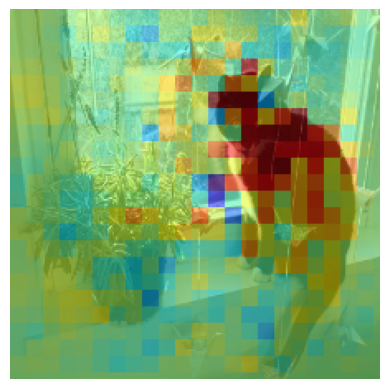

In [10]:
plt.figure()
plt.imshow(cat_sensitivity_map)
plt.axis("off")
plt.show()

The reddest areas of the predicted image are around the cat, which explains the "Egyptian_cat" prediction.
Even though classify returns the most likely class, there were other highly probably predictions. The class "tabby" was network's third choice.
We can change the third input to the occlusion_sensitivity function to another prediction to see what's important to another class.

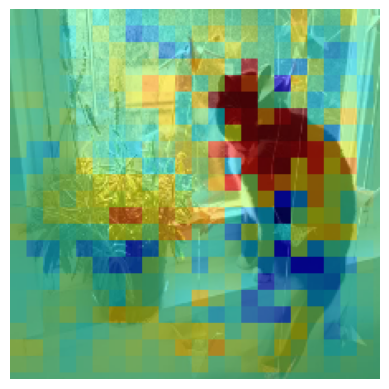

In [11]:
sensitivity_map = occlusion_sensitivity(model, cat, 281, 10)
cat_sensitivity_map = cv.addWeighted(cv.resize(cat, dsize=(224, 224)), 0.5, sensitivity_map.astype(np.uint8), 0.5, 0.0)

plt.figure()
plt.imshow(cat_sensitivity_map)
plt.axis("off")
plt.show()